In [2]:
from pathlib import Path
import pickle

import pandas as pd
import numpy as np
import inspect
import xarray as xr

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.utils.config import Config
import neuralhydrology.modelzoo
from neuralhydrology.nh_run import start_run, eval_run, finetune

In [2]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU or MacOS with Metal support
if torch.cuda.is_available() or torch.backends.mps.is_available():
    start_run(config_file=Path("1_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("1_basin.yml"), gpu=-1)

2025-06-04 04:10:47,602: Logging to d:\github\neuralhydrology\neuralhydrology\own\MtslstmCMAL\runs\test_run_0406_041047\output.log initialized.
2025-06-04 04:10:47,603: ### Folder structure created at d:\github\neuralhydrology\neuralhydrology\own\MtslstmCMAL\runs\test_run_0406_041047
2025-06-04 04:10:47,603: ### Run configurations for test_run
2025-06-04 04:10:47,604: experiment_name: test_run
2025-06-04 04:10:47,604: use_frequencies: ['1h', '1D']
2025-06-04 04:10:47,605: train_basin_file: 1_basin.txt
2025-06-04 04:10:47,606: validation_basin_file: 1_basin.txt
2025-06-04 04:10:47,606: test_basin_file: 1_basin.txt
2025-06-04 04:10:47,607: train_start_date: 1999-10-01 00:00:00
2025-06-04 04:10:47,608: train_end_date: 2008-09-30 00:00:00
2025-06-04 04:10:47,608: validation_start_date: 1996-10-01 00:00:00
2025-06-04 04:10:47,609: validation_end_date: 1999-09-30 00:00:00
2025-06-04 04:10:47,610: test_start_date: 1989-10-01 00:00:00
2025-06-04 04:10:47,610: test_end_date: 1996-09-30 00:00:00

In [3]:
run_dir = Path("runs/test_run_0406_041047")
eval_run(run_dir=run_dir, period="test")

2025-06-04 04:30:34,293: No specific hidden size for frequencies are specified. Same hidden size is used for all.
2025-06-04 04:30:34,302: Using the model weights from runs\test_run_0406_041047\model_epoch050.pt
# Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]2025-06-04 04:30:34,320: ## Warning: Hourly nldas_hourly NetCDF file not found. Falling back to slower csv files.
DEBUG: Processing frequency: 1D
DEBUG: Head object for '1D': CMAL(
  (fc1): Linear(in_features=20, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (_softplus): Softplus(beta=2, threshold=20.0)
)
DEBUG: Class name of head for '1D': CMAL
DEBUG_CMAL_MEAN_EXECUTION: Calculating CMAL mean for frequency 1D
DEBUG: Processing frequency: 1h
DEBUG: Head object for '1h': CMAL(
  (fc1): Linear(in_features=20, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (_softplus): Softplus(beta=2, threshold=20.0)
)
DEBUG: Class name of head for '1h': CM

In [13]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01022500'])

In [18]:
# Load validation results from the last epoch
df = pd.read_csv(run_dir / "validation" / "model_epoch050" / "validation_metrics.csv", dtype={'basin': str})
df = df.set_index('basin')

# Compute the median NSE from all basins, where discharge observations are available for that period
print(f"Median NSE of the validation period {df['NSE_1D'].median():.3f}")

Median NSE of the validation period 0.547


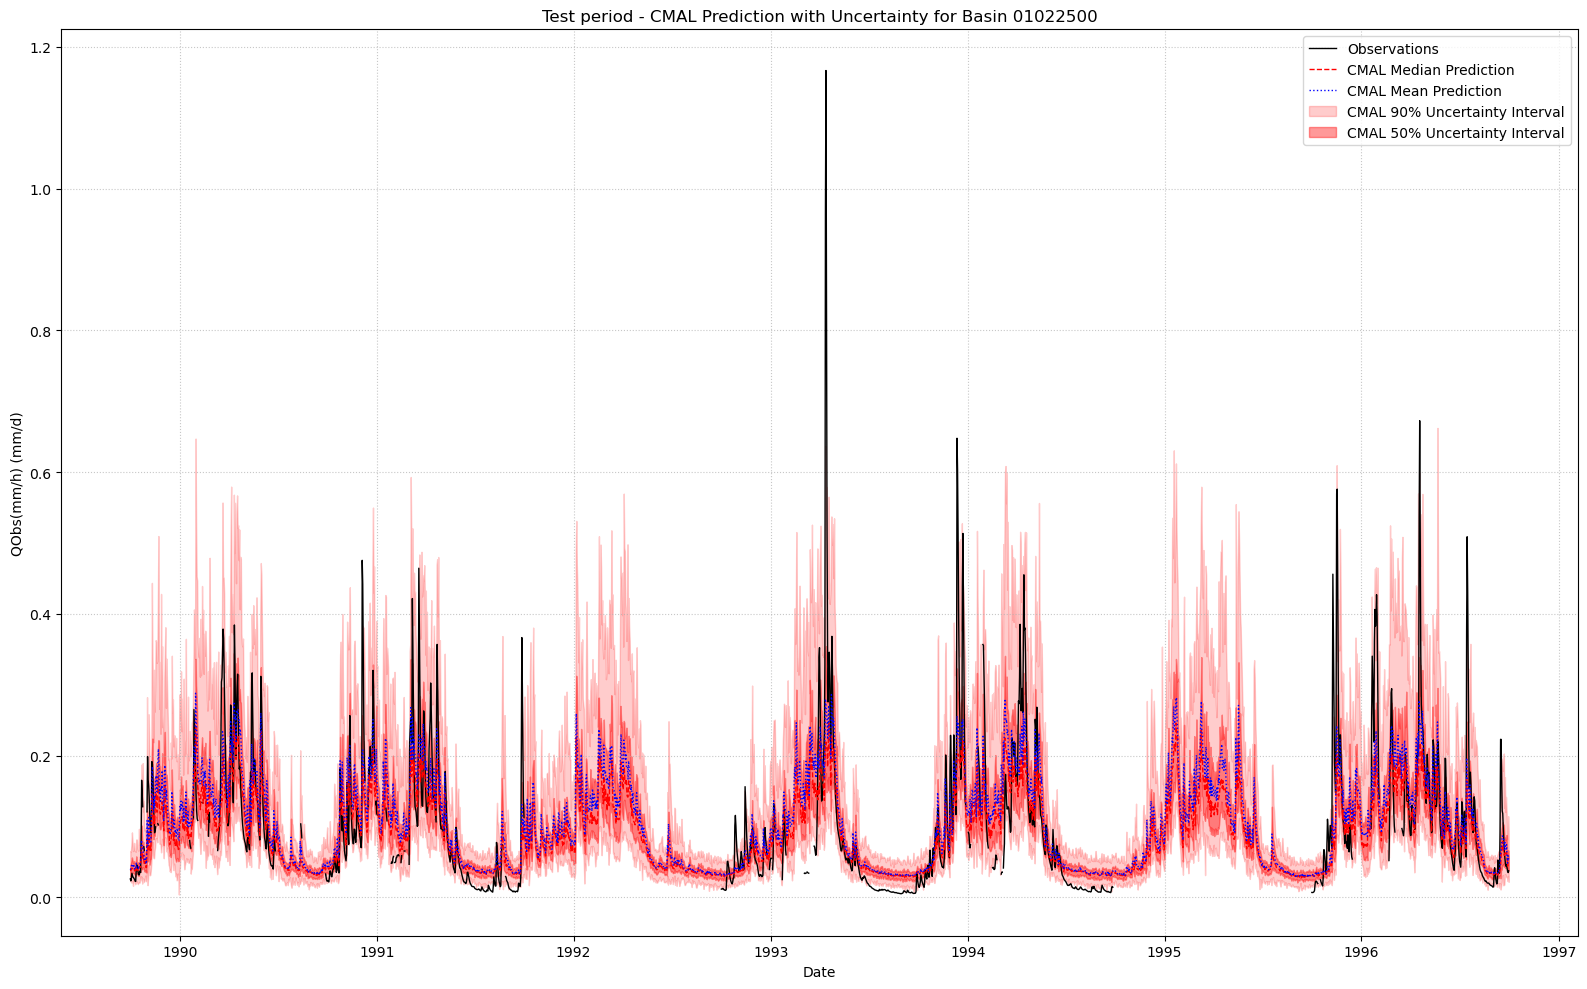

In [21]:
basin_id = '01022500' # Your basin ID
freq = '1D'           # Your frequency key
target_variable = 'QObs(mm/h)' # Your target variable name

# --- 1. Extract Observations ---
# Get the original xarray DataArray for observations. Its shape is (2557, 24)
qobs_original_xr = results[basin_id][freq]['xr'][f'{target_variable}_obs']

# --- 2. Extract Simulated Output with Samples ---
# Get the original xarray DataArray for simulated data.
qsim_with_samples_original_xr = results[basin_id][freq]['xr'][f'{target_variable}_sim']

# --- Prepare data for plotting (flattening to single 1D series) ---

# Get the daily dates coordinate from the original observation DataArray.
# Assuming 'date' is the dimension name for days, and the other for hours (e.g., 'time_step').
# You might need to adjust 'date' and 'time_step' to your actual dimension names.
daily_dates_coord = qobs_original_xr['date'].values
num_hours_per_day = qobs_original_xr.sizes[qobs_original_xr.dims[1]] # Assuming the second dim is hourly

# Construct the full hourly datetime index for the X-axis for plotting
full_hourly_dates = []
for d in daily_dates_coord:
    for h in range(num_hours_per_day):
        full_hourly_dates.append(pd.to_datetime(d) + pd.Timedelta(hours=h))
full_hourly_dates = np.array(full_hourly_dates) # This will be (2557 * 24,) = (61368,)

# Flatten the observed discharge data into a single 1D NumPy array
qobs_flat_np = qobs_original_xr.values.flatten() # (2557, 24) -> (61368,)

# --- 3. Calculate Quantiles from Samples and flatten ---
# Convert the xarray DataArray to a NumPy array
qsim_data_np = qsim_with_samples_original_xr.values # e.g., (2557, 24, 100)

# Calculate percentiles and mean across the 'samples' dimension (axis=-1)
# Then, flatten each result to a single 1D NumPy array for plotting
median_sim_flat_np = np.nanpercentile(qsim_data_np, 50, axis=-1).flatten() # (2557, 24) -> (61368,)
q25_flat_np = np.nanpercentile(qsim_data_np, 25, axis=-1).flatten()
q75_flat_np = np.nanpercentile(qsim_data_np, 75, axis=-1).flatten()
lower_bound_90ci_flat_np = np.nanpercentile(qsim_data_np, 5, axis=-1).flatten()
upper_bound_90ci_flat_np = np.nanpercentile(qsim_data_np, 95, axis=-1).flatten()
mean_sim_flat_np = np.nanmean(qsim_data_np, axis=-1).flatten()

# --- Create new 1D xarray DataArrays for consistent plotting ---
# These DataArrays will now all be 1D, with 'date' as their single dimension.
# This ensures compatibility for plotting with Matplotlib.
qobs = xr.DataArray(qobs_flat_np, coords={'date': full_hourly_dates}, dims=['date'])
median_sim = xr.DataArray(median_sim_flat_np, coords={'date': full_hourly_dates}, dims=['date'])
q25 = xr.DataArray(q25_flat_np, coords={'date': full_hourly_dates}, dims=['date'])
q75 = xr.DataArray(q75_flat_np, coords={'date': full_hourly_dates}, dims=['date'])
lower_bound_90ci = xr.DataArray(lower_bound_90ci_flat_np, coords={'date': full_hourly_dates}, dims=['date'])
upper_bound_90ci = xr.DataArray(upper_bound_90ci_flat_np, coords={'date': full_hourly_dates}, dims=['date'])
mean_sim = xr.DataArray(mean_sim_flat_np, coords={'date': full_hourly_dates}, dims=['date'])

# --- 4. Plotting with Matplotlib for Uncertainty ---
fig, ax = plt.subplots(figsize=(16, 10))

# Plot observations (using the new 1D qobs DataArray)
ax.plot(qobs['date'].values, qobs.values, color='black', label='Observations', linewidth=1)

# Plot median prediction
ax.plot(median_sim['date'].values, median_sim.values, color='red', linestyle='--', label='CMAL Median Prediction', linewidth=1)
ax.plot(mean_sim['date'].values, mean_sim.values, color='blue', linestyle=':', label='CMAL Mean Prediction', linewidth=1)

# Plot uncertainty bands using fill_between
# 90% Confidence Interval (between 5th and 95th percentiles)
ax.fill_between(
    lower_bound_90ci['date'].values, # X-axis values (full hourly dates)
    lower_bound_90ci.values,         # Y1 values (flattened to 1D)
    upper_bound_90ci.values,         # Y2 values (flattened to 1D)
    color='red',
    alpha=0.2, # Lighter transparency for the wider band
    label='CMAL 90% Uncertainty Interval'
)

# 50% Confidence Interval (between 25th and 75th percentiles)
ax.fill_between(
    q25['date'].values,
    q25.values,
    q75.values,
    color='red',
    alpha=0.4, # Darker transparency for the narrower band
    label='CMAL 50% Uncertainty Interval'
)

ax.set_ylabel(f"{target_variable} (mm/d)")
ax.set_xlabel("Date")
ax.set_title(f"Test period - CMAL Prediction with Uncertainty for Basin {basin_id}")
ax.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()